# Постановка задачи

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Исходные данные содержат параметры добычи и очистки.
Модель будет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Шаг 1. Подготовка данных

## Шаг 1.1. Загрузка данных и их анализ

In [71]:
import pandas as pd
import numpy as np
from statistics import mean
import random
import os
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
path_review_0 = '/datasets/gold_recovery_train_new.csv'
path_review_1 = '/datasets/gold_recovery_test_new.csv'
path_review_2 = '/datasets/gold_recovery_full_new.csv'
paths_review = [path_review_0, path_review_1, path_review_0]

my_path_0 = '/Users/Ideapad S145/Desktop/Data_Science/Сборный проект №2/gold_recovery_train_new.csv'
my_path_1 = '/Users/Ideapad S145/Desktop/Data_Science/Сборный проект №2/gold_recovery_test_new.csv'
my_path_2 = '/Users/Ideapad S145/Desktop/Data_Science/Сборный проект №2/gold_recovery_full_new.csv'
my_paths = [my_path_0, my_path_1, my_path_2]

df = []
for path_review, my_path in zip(paths_review, my_paths):
    if os.path.exists(path_review):
        df.append(pd.read_csv(path_review, sep=',', index_col='date'))
    elif os.path.exists(my_path):
        df.append(pd.read_csv(my_path, sep=',', index_col='date'))
    else:
        print("Проверьте правильность пути к датасету")

Переведем даты в индекса в формат datetime

In [3]:
df[0].index = pd.to_datetime(df[0].index, format='%Y.%m.%d %H:%M:%S')
df[1].index = pd.to_datetime(df[1].index, format='%Y.%m.%d %H:%M:%S')
df[2].index = pd.to_datetime(df[2].index, format='%Y.%m.%d %H:%M:%S')

**Посмотрим на импортируемые данные**

Это обучающая выборка

In [4]:
df[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

Это тестовая выборка

In [5]:
df[1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

Это исходная выборка

In [6]:
df[2].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

По условию задания значения в полях близки друг к другу, а значит можно заполнить пропуски находящимися рядом близкими значениями.<br>
Изначальное разбиение могло пройти по пропускам, тогда если мы применим метод заполнения пропуском ближайшим значением, то можем получить разные значения в обучающей/тестовой выборках и исходном датасете.<br>
Сделаем так:<br>
Заполним пропуски ближайшеми значениями в исходном датасете, а затем сделаем его разбиение по индексам датасетов обучающей и тестовой выборок.<br>
Для начала посмотрим совпадают ли количество уникальные значений индекса (поле date) с длиной исходного датасета.

In [7]:
print('разница между количеством уникальных индексов и длиной датасета = ', len(df[2].index.unique()) - len(df[2]))

разница между количеством уникальных индексов и длиной датасета =  0


Все индексы уникальны. 
Сделаем замену пропусков в исходном датасете df[2]

In [8]:
for column in df[2].columns:
    df[2][column] = df[2][column].fillna(method='bfill')

Сделаем новую нарезку на обучающую и тестовую выборку по уже имеющимся индексам. Т.е. повторим датасеты обучающей и тестовой выборки, но уже они будут без пропусков. Выборки сделаем с такими же полями как и были на импорте изначально.

In [9]:
df[0] = df[2][df[2].index.isin(df[0].index)][df[0].columns]
df[1] = df[2][df[2].index.isin(df[1].index)][df[1].columns]

**Общее описание к датасетам с учетом технологического процесса**<br>
Первый и второй датасеты (обучающая и тестовая выборка соответственно) это подмножества третьего датасета (исходных данных), которые соотносятся как 0,73 : 0,27.<br>
Все поля датасета имеют тип float.<br>
Дата и время индексное поле (мы так сделали при импорте данных).<br>
Есть небольшие пропуски данных в полях и об этом говорится в описание к задаче и эти пропуски заполнили соседними значениями.<br>
В данном датасете мы видим показатели по каждой порции сырья проходящего по все цепочке технологического процесса. Есть базовые этапы: rougher (флотация), primary_cleaner (первичная очистка) и secondary_cleaner (вторичная очистка). В рамках технологического процесса есть два результирующих признака - rougher.output.recovery после этапа флотации и final.output.recovery после этапа вторичная очистка - которые характеризуют эффективность обработки коонкертного сырья при заданном технологическом процессе.<br>
В рамках каждого этапа есть свои блоки параметров - input (параметры сырья на входе), output (параметры продукта на выходе), 
state (параметры, характеризующие текущее состояние этапа обработки сырья) и calculation (расчётные характеристики).<br>

По существу есть два этапа - это производство чернового концентрата и производство финального концентрата.

**На этапе производства чернового концентрата идут следующие процессы:**<br>

А. Осуществляется загрузка сырья и химикатов за что отвечают параметры:<br>
- rougher.input.feed_ag;
- rougher.input.feed_pb;
- rougher.input.feed_rate;
- rougher.input.feed_size;
- rougher.input.feed_sol;
- rougher.input.feed_au;
- rougher.input.floatbank10_sulfate;
- rougher.input.floatbank10_xanthate;
- rougher.input.floatbank11_sulfate;
- rougher.input.floatbank11_xanthate.<br>

B. Непосредственно флотация за что отвечают параметры<br>
- rougher.state.floatbank10_a_air;
- rougher.state.floatbank10_a_level;
- rougher.state.floatbank10_b_air;
- rougher.state.floatbank10_b_level;
- rougher.state.floatbank10_c_air;
- rougher.state.floatbank10_c_level;
- rougher.state.floatbank10_d_air;
- rougher.state.floatbank10_d_level;
- rougher.state.floatbank10_e_air;
- rougher.state.floatbank10_e_level;
- rougher.state.floatbank10_f_air;
- rougher.state.floatbank10_f_level.

После флотации осуществляются замеры полученного концентрата - это следующие параметры:
- rougher.output.concentrate_ag;
- rougher.output.concentrate_pb;
- rougher.output.concentrate_sol;
- rougher.output.concentrate_au.<br>

А также осуществляются замеры по отвалу - это следующие параметры:
- rougher.output.tail_ag;
- rougher.output.tail_pb;
- rougher.output.tail_sol;
- rougher.output.tail_au.

На основании замеров концентрата и отвала считается целевая характеристика процесса производства чернового концентрата -  это эффективность обогащения чернового концентрата или rougher.output.recovery в нашем датасете. <br>
Рассчет эффективности обогащения чернового концентрата ведется по известной аналитической формуле.<br>
Таким образом, возникает промежуточная задача машинного обучения - рассчитать значение эффективности обогащения чернового концентрата на основе входных данных - параметры рудного сырья и параметров флотационной установки без проведения аналитических расчетов по известной формуле, т.е. без прохода реального сырья по данному этапу технологического процесса. Т.е. мы должны моделью машинного обучения заменить аналитические расчеты по известной формуле.<br>
Для построения модели расчета значения эффективности обогащения чернового концентрата нам вместо всего набора полей данного этапа понадобятся следующие поля:
- rougher.input.feed_ag;
- rougher.input.feed_pb;
- rougher.input.feed_rate;
- rougher.input.feed_size;
- rougher.input.feed_sol;
- rougher.input.feed_au;
- rougher.input.floatbank10_sulfate;
- rougher.input.floatbank10_xanthate;
- rougher.state.floatbank10_a_air;
- rougher.state.floatbank10_a_level;
- rougher.state.floatbank10_b_air;
- rougher.state.floatbank10_b_level;
- rougher.state.floatbank10_c_air;
- rougher.state.floatbank10_c_level;
- rougher.state.floatbank10_d_air;
- rougher.state.floatbank10_d_level;
- rougher.state.floatbank10_e_air;
- rougher.state.floatbank10_e_level;
- rougher.state.floatbank10_f_air;
- rougher.state.floatbank10_f_level.
- **rougher.output.recovery** (целевой признак).

Признаки rougher.input.floatbank11_sulfate и rougher.input.floatbank11_xanthate исключим из модели, т.к. они не участвуют в производстве чернового концентрата - в блоке rougher.state нет показаний по установке floatbank11

Primary_cleaner (первичная очистка) и secondary_cleaner (вторичная очистка) - это по сути внутренние этапы процесса получения финального концентрата из полученного чернового концентрата.<br>
На этапе первичной и вторичной очистки на вход подаются черновой концентрат и химикаты и после этого сырье и химикаты пропускаются по двум этапам с промежуточным получением отвала и анализом концентрата после первичной очистки. Соответственно параметры процесса (floatbank) на первичной очистке и вторичной очистке разные.<br>

Таким образом, формируется окончательная задача для машинного обучения, которая моделировала бы значения эффективности процесса получения финального концентрата по поступившему на вход рудному сырью и параметрам технологической обработки руды.<br>

## Шаг 1.2. Проверка расчета эффективности обогащения.

Напишем функцию, которая по заданной формуле считает эффективность производства чернового концентрата на основании выходных данных по концентрату в конечном продукте и посчитаем MAE с фактическим значением в столбце rougher.output.recovery.

In [10]:
def rougher(c, f, t):
    try:
        a = c * (f - t)
        b = f * (c - t)
        return  a/b*100
    except:
        return 0

In [11]:
rougher_analytic = [rougher(x['rougher.output.concentrate_au'], 
                            x['rougher.input.feed_au'],
                            x['rougher.output.tail_au']) for _, x in df[0].iterrows()]
                    
print('MAE = ', mean_absolute_error(df[0]['rougher.output.recovery'], rougher_analytic))

MAE =  9.745418284091104e-15


**Резюме:**<br>
Расчеты по формуле совпали с значениями в поле "rougher.output.recovery".<br>

## Шаг 1.3. Анализ признаков, недоступных в тестовой выборке. 

Пoсмотрим какие признаки есть в обучающей выборке, но которых нет тестовой выборке

In [12]:
#set(df[0].columns).difference(set(df[1].columns))

Сгруппируем эти признаки по этапам и блокам.<br>

rougher.output.recovery<br>
rougher.calculation.sulfate_to_au_concentrate<br>
rougher.calculation.floatbank10_sulfate_to_au_feed<br>
rougher.calculation.floatbank11_sulfate_to_au_feed<br>
rougher.calculation.au_pb_ratio<br>
rougher.output.concentrate_ag<br>
rougher.output.concentrate_pb<br>
rougher.output.concentrate_sol<br>
rougher.output.concentrate_au<br>
rougher.output.tail_ag<br>
rougher.output.tail_pb<br>
rougher.output.tail_sol<br>
rougher.output.tail_au
<br>
primary_cleaner.output.concentrate_ag<br>
primary_cleaner.output.concentrate_au<br>
primary_cleaner.output.concentrate_pb<br>
primary_cleaner.output.concentrate_sol<br>
primary_cleaner.output.tail_ag<br>
primary_cleaner.output.tail_au<br>
primary_cleaner.output.tail_pb<br>
primary_cleaner.output.tail_sol<br>
<br>
final.output.recovery',<br>
final.output.concentrate_ag<br>
final.output.concentrate_au<br>
final.output.concentrate_pb<br>
final.output.concentrate_sol<br>
final.output.tail_ag<br>
final.output.tail_au<br>
final.output.tail_pb<br>
final.output.tail_sol<br>
secondary_cleaner.output.tail_ag<br>
secondary_cleaner.output.tail_au<br>
secondary_cleaner.output.tail_pb<br>
secondary_cleaner.output.tail_sol

Мы видим, что в тестовой выборке отсутствуют следующие признаки:
- показатели эффективности производства чернового и финального концентрата;
- расчетные характеристики для этапа флотации;
- характеристики концентрации металлов и веществ в промежуточном продукте и финальном; 
- характеристики концентрации металлов и веществ в отвальных хвостах; 

С характеристиками промежуточного продукта и отвалами все понятно - это конечные характеристики этапов флотации, первичной и вторичной очистики, т.е. на входе загружают сырье на выходе получают концентрат и отвал.

Посмотрим параметры блока rougher.calculation<br>
Эти характеристики похожи на какие-то промежуточные технические расчеты по техпроцессу соотношение различных компонентов в процессе флотации.

In [13]:
calculation = pd.DataFrame(df[0][['rougher.calculation.sulfate_to_au_concentrate',
                                    'rougher.calculation.floatbank10_sulfate_to_au_feed',
                                    'rougher.calculation.au_pb_ratio']])
calculation.columns = ['sulfate_to_au_concentrate',
                        'floatbank10_sulfate_to_au_feed',
                        'au_pb_ratio']
calculation.describe()

,sulfate_to_au_concentrate,floatbank10_sulfate_to_au_feed,au_pb_ratio
count,1.414900e+04,14149.000000,14149.000000
mean,4.038276e+04,3456.591152,2.367314
std,3.801302e+05,5772.306600,0.873551
min,-4.223520e+07,-486.598675,-0.010548
25%,3.999439e+04,2527.106558,1.999588
50%,4.368392e+04,2976.126894,2.249275
75%,4.775946e+04,3716.340219,2.660896
max,3.428099e+06,629638.977914,39.379272


Непонятно что это. Посмотрим изменение этих показателей в динамике на графиках. Чтобы не смотреть по дням перейдем к среднемесячным показателям. А для это сделаем поля 'month', 'year' и 'year_month'.

In [14]:
calculation['month'] = calculation.index.month
calculation['year'] = calculation.index.year
calculation['year_month'] = calculation['month'].astype('str') + '-' + calculation['year'].astype('str')

In [15]:
calculation_avg_monthly = calculation.pivot_table(index='year_month', 
                                                  values=['sulfate_to_au_concentrate',
                                                            'floatbank10_sulfate_to_au_feed',
                                                            'au_pb_ratio'])

**Динамика показателя sulfate_to_au_concentrate**

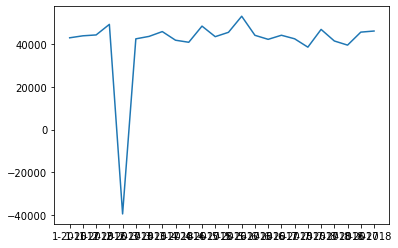

In [16]:
plt.plot(calculation_avg_monthly.index, calculation_avg_monthly.sulfate_to_au_concentrate)

Значение данного признака стабильно находятся около 4000. Это какой-то динамический признак характеризующий процесс флотации. Есть несколько значений, которые находятся около -4000. Это скорее всего ошибка. Скорее всего нужно поменять знак у отрицательных значений данного признака, но на 100% я в этом не уверен, потому что не знаком в технологическим процессом. 

In [17]:
df[0]['rougher.calculation.floatbank10_sulfate_to_au_feed'] = abs(df[0]['rougher.calculation.floatbank10_sulfate_to_au_feed'])

**Динамика показателя floatbank10_sulfate_to_au_feed**

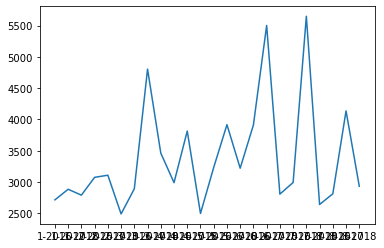

In [18]:
plt.plot(calculation_avg_monthly.index, calculation_avg_monthly.floatbank10_sulfate_to_au_feed)

На основании динамики этого показателя можно сказать, что это тоже какая-то динамическая характеристика технологического процесса. 

**Динамика показателя au_pb_ratio**

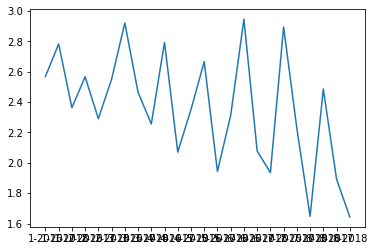

In [19]:
plt.plot(calculation_avg_monthly.index, calculation_avg_monthly.au_pb_ratio)

Это тоже показатель, характеризующий  внутренние параметры техпроцесса флотации. Причем интересно, что показатель au_pb_ratio имеет устойчивую тенденцию на снижение во временном интервале. Это может указывать на то, что с этим показателем активно работают на снижение и возможно, что с помощью управления показателями sulfate_to_au_concentrate и floatbank10_sulfate_to_au_feed.

Больше всего интересны показатели блока output - параметры концентрации металлов и отвальные хвосты и прежде всего output.concentrate.

Посмотрим, что из себя представляет признаки output.concentrate и output.tail. Начнем с золота и рассмотрим три признака - rougher.input.feed_au, rougher.output.concentrate_au и rougher.output.tail_au

# Шаг 2. Анализа данных

## Шаг 2.1. Анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки. 

**Проанализируем золото (Aurum).**

In [20]:
aurum = df[0][['rougher.input.feed_au', 
                           'rougher.output.concentrate_au', 
                           'primary_cleaner.output.concentrate_au',
                           'final.output.concentrate_au']]
aurum_describe = aurum.describe().transpose()
display(aurum_describe)

,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_au,14149.0,7.866577,1.919506,0.01,6.596217,7.649138,9.066976,13.126043
rougher.output.concentrate_au,14149.0,19.439958,3.765192,0.00,18.432161,19.947312,21.392714,28.146838
primary_cleaner.output.concentrate_au,14149.0,32.386836,5.798843,0.00,30.857764,33.225835,35.330145,45.933934
final.output.concentrate_au,14149.0,44.003792,4.905261,0.00,43.276111,44.872436,46.166425,52.756638


Посмотрим график изменения среднего значения concentrate от этапа к этапу

Text(0.5, 1.0, 'Динамика среднего значения концентрации золота по этапам')

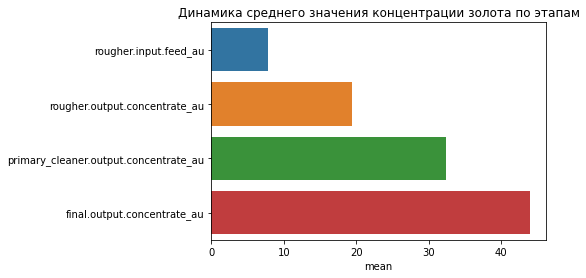

In [23]:
ax_1 = sns.barplot(y=aurum_describe.index, x=aurum_describe['mean'])
ax_1.set_title(f'Динамика среднего значения концентрации золота по этапам', fontsize=12)

Посмотрим распределение концентрации золота в промежуточном и финальном продукте каждого этапа технологического процесса.

Text(0.5, 1.0, 'Динамика распределения концентрации золота на этапах техпроцесса')

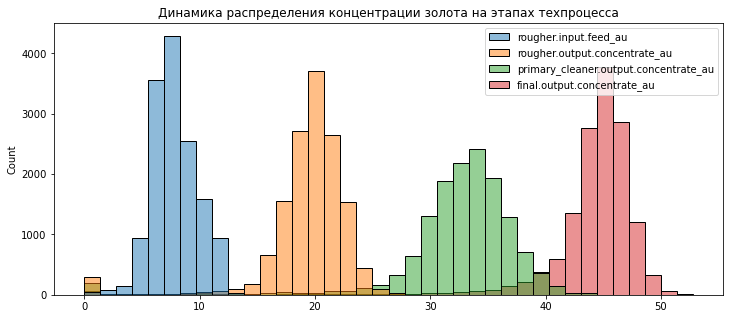

In [24]:
fig = plt.figure(figsize=(12,5))
ax_1 = sns.histplot(data = aurum)
ax_1.set_title(f'Динамика распределения концентрации золота на этапах техпроцесса', fontsize=12)

Очевидно из таблицы графиков, что показатели конецнтрации золота растут от этапа к этапу и достигают своего максимума к финальному этапу. Среднее значение концентрации золота увеличивается в четыре раза от этапа рудного сырья до финального концентрата. Можно говорить про эти показатели, что они характеризуют конверсию этапов очистки и чем выше конверсия, тем эффективнее производство.<br>
Также мы наблюдаем длиные хвосты слева и накопление объектов в районе нуля для каждого этапа. Это означает, что есть объекты с неффективным обогащением на каждом этапе. Из этого можно сделать два предположения:
Первое предположение, что это путь исходной порции сырья с низкой концентрацией золота, т.е. рудное сырье с небольшим или близким к нулю концентрацией золота на входе (input.feed_au) в техпроцессе выдает небольшие или близкие к нулю концентрации золота на выходе (final.output.concentrate_au).
Второе предположение, что это ошибки измерения.
Проверим. Возьмем объекты рудного сырья с высоким содержанием золота на входе больше  6,6% - это первая квантиль. Если будут нули на других этапах, то значит это ошибки измерения.

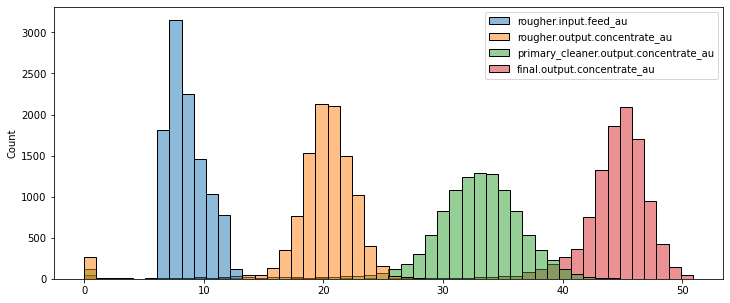

In [25]:
smale_feed_au = aurum[aurum['rougher.input.feed_au'] > 6.6]
fig = plt.figure(figsize=(12,5))
ax_1 = sns.histplot(data=[smale_feed_au['rougher.input.feed_au'],
                          smale_feed_au['rougher.output.concentrate_au'],
                          smale_feed_au['primary_cleaner.output.concentrate_au'],
                          smale_feed_au['final.output.concentrate_au']], bins=50)

Для порций рудного сырья с хорошей концентрацией золота мы видим такие же выбросы около нуля, значит это ошибки измерения.

**Проанализируем серебро (Argentum).**

In [26]:
argentum = df[0][['rougher.input.feed_ag', 
                              'rougher.output.concentrate_ag', 
                              'primary_cleaner.output.concentrate_ag',
                              'final.output.concentrate_ag']]
argentum_describe = argentum.describe().transpose()
display(argentum_describe)

,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_ag,14149.0,8.579195,1.896284,0.01,7.132802,8.156092,9.918304,14.596026
rougher.output.concentrate_ag,14149.0,11.775812,2.731747,0.00,10.486871,11.747362,13.426419,24.480271
primary_cleaner.output.concentrate_ag,14149.0,8.200916,2.005185,0.00,7.107126,8.226247,9.504924,16.081632
final.output.concentrate_ag,14149.0,5.141915,1.369610,0.00,4.211500,4.994607,5.859495,16.001945


Посмотрим график изменения среднего значения concentrate по этапам.

Text(0.5, 1.0, 'Динамика среднего значения концентрации серебра')

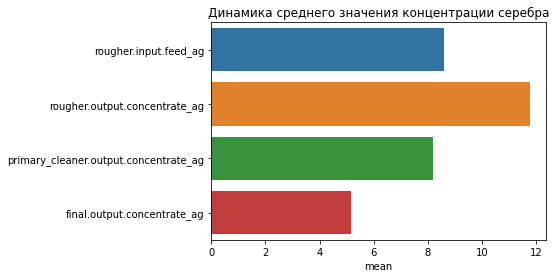

In [27]:
ax_1 = sns.barplot(y=argentum_describe.index, x=argentum_describe['mean'])
ax_1.set_title(f'Динамика среднего значения концентрации серебра', fontsize=12)

Посмотрим распределение концентрации серебра в промежуточном и финальном продукте каждого этапа технологического процесса.

Text(0.5, 1.0, 'Динамика распределения концентрации серебра на этапах техпроцесса')

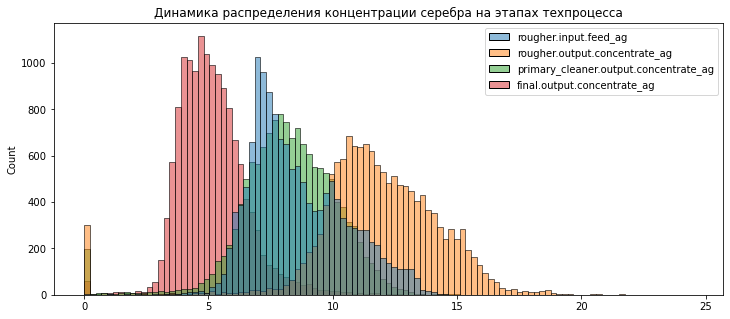

In [28]:
fig = plt.figure(figsize=(12,5))
ax_1 = sns.histplot(data = argentum)
ax_1.set_title(f'Динамика распределения концентрации серебра на этапах техпроцесса', fontsize=12)

Анализируя таблицу и графики, мы не видим такого же устойчивого роста показателей concentrate как по золоту. Это может свидетельствовать о том, что тех процесс не настроен на обогащение серебра и серебро является побочным продуктом производства.

**Проанализируем свинец (Plumbum).**

In [29]:
plumbum = df[0][['rougher.input.feed_pb', 
                             'rougher.output.concentrate_pb', 
                             'primary_cleaner.output.concentrate_pb',
                             'final.output.concentrate_pb']]
plumbum_describe = plumbum.describe().transpose()
display(plumbum_describe)

,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_pb,14149.0,3.506501,1.089049,0.01,2.766515,3.414267,4.220115,7.142594
rougher.output.concentrate_pb,14149.0,7.664555,1.856279,0.00,6.850501,7.760435,8.601927,13.617072
primary_cleaner.output.concentrate_pb,14149.0,9.568457,2.708364,0.00,8.314746,9.919856,11.298191,17.081278
final.output.concentrate_pb,14149.0,10.132841,1.654932,0.00,9.296833,10.297013,11.170578,17.031899


Посмотрим график изменения среднего значения concentrate от этапа к этапу

Text(0.5, 1.0, 'Динамика среднего значения концентрации свинцат по этапам')

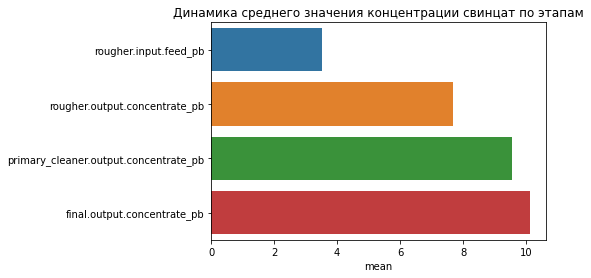

In [30]:
ax_1 = sns.barplot(y=plumbum_describe.index, x=plumbum_describe['mean'])
ax_1.set_title(f'Динамика среднего значения концентрации свинцат по этапам', fontsize=12)

Посмотрим распределение концентрации свинца в промежуточном и финальном продукте каждого этапа технологического процесса.

Text(0.5, 1.0, 'Динамика распределения концентрации свинца на этапах техпроцесса')

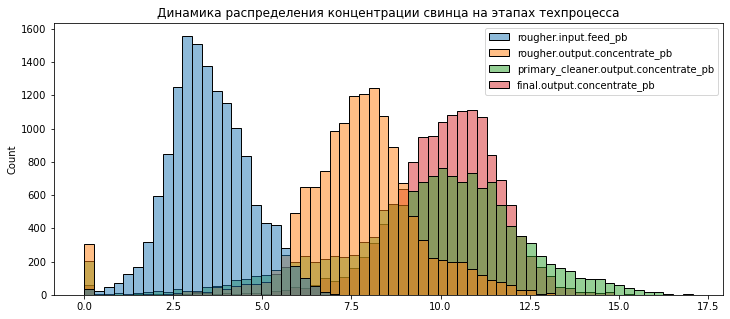

In [31]:
fig = plt.figure(figsize=(12,5))
ax_1 = sns.histplot(data = plumbum)
ax_1.set_title(f'Динамика распределения концентрации свинца на этапах техпроцесса', fontsize=12)

Анализируя таблицу и графики по свинцу, мы видим рост показателей  concentrate и tail от этапа к этапу также как и у золота. Золото и свинец находятся рядом в таблице Менделеева и плотности этих металлов близки к друг к другу. Исходя из этого можно сделать вывод, что на этапе флотации, первичной и вторичной очистки вместе с золотом обогащается и свинец. Похоже такая особенность данного технологического процесса и разделение золота и свинца в нем не предусмотрено. С этой проблемой я думаю технологи борются и мы это видим по контролю показателя au_pb_ratio.

## Шаг 2.2. Анализ распределения размеров гранул сырья на обучающей и тестовой выборках. 

По условиям задачи нам уже дано разделение исходных данных на обучающую и тестовую. Так как размер гранул влияет на химические и физические процессы в рамках флотации и очистки, то необходимо проверить характер распределение размеров гранул в обоих выборках, а также сравнить средние значения на предмет равенства средней величины размеров гранул. <br>
Проанализируем размеры гранул в обучающей и тестовой выборках для этапов флотации и первичной очистки.

**Посмотрим распределение гранул в обучающей и тестовой выборках для этапа флотации (rougher)**

Text(0.5, 1.0, 'Ящик с усами размера гранул на обучающей выборке')

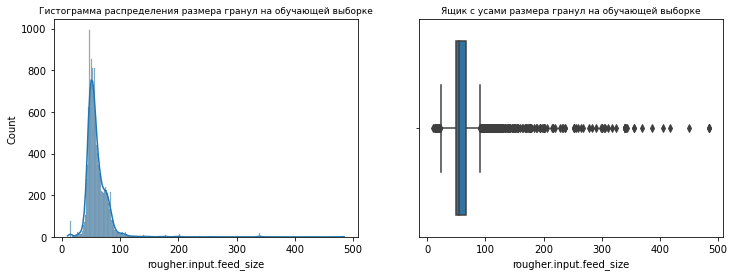

In [32]:
# Распределение и ящик с усами размера гранул для обучающей выборки
feature = df[0]['rougher.input.feed_size']

fig = plt.figure(figsize=(12,4))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
sns.histplot(x=feature, kde=True, ax=ax_1)
ax_2 = sns.boxplot(x=feature, ax=ax_2)
ax_1.set_title('Гистограмма распределения размера гранул на обучающей выборке', fontsize=9)
ax_2.set_title('Ящик с усами размера гранул на обучающей выборке', fontsize=9)

Text(0.5, 1.0, 'Ящик с усами размера гранул на обучающей выборке')

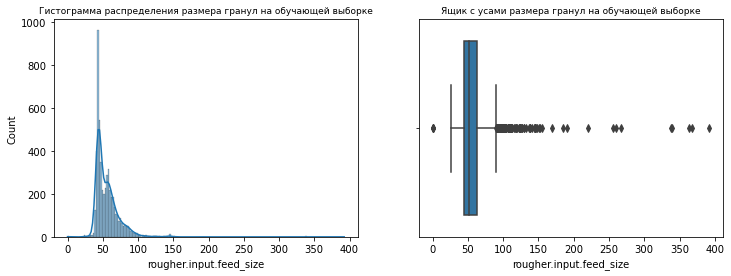

In [33]:
# Распределение и ящик с усами размера гранул для тестовой выборки
feature = df[1]['rougher.input.feed_size']

fig = plt.figure(figsize=(12,4))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
ax_1 = sns.histplot(x=feature, kde=True, ax=ax_1)
ax_2 = sns.boxplot(x=feature, ax=ax_2)
ax_1.set_title('Гистограмма распределения размера гранул на обучающей выборке', fontsize=9)
ax_2.set_title('Ящик с усами размера гранул на обучающей выборке', fontsize=9)

Мы видим длинные хвосты в обоих гистограммах и соответственно статистические выбросы на boxplot.<br>
В целом распределения размеров гранул на обучающей и тестовых выборках очень похоже. <br>
Уменьшим границы областей значений (xlim), т.е. уберем с графика выбросы.

Text(0.5, 1.0, 'Гистограмма распределения размера гранул на тестовой выборке')

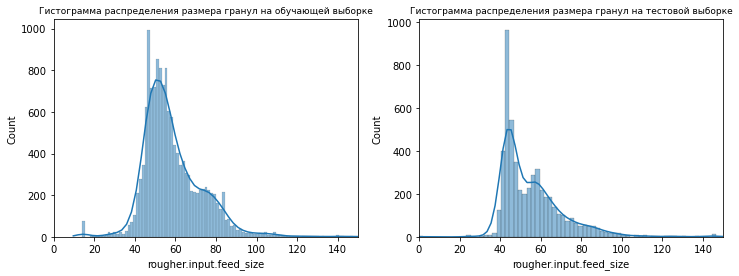

In [34]:
feature_0 = df[0]['rougher.input.feed_size']
feature_1 = df[1]['rougher.input.feed_size']

fig = plt.figure(figsize=(12,4))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
ax_1 = sns.histplot(x=feature_0, kde=True, ax=ax_1)
ax_1.set_xlim([0, 150])
ax_2 = sns.histplot(x=feature_1, kde=True, ax=ax_2)
ax_2.set_xlim([0, 150])
ax_1.set_title('Гистограмма распределения размера гранул на обучающей выборке', fontsize=9)
ax_2.set_title('Гистограмма распределения размера гранул на тестовой выборке', fontsize=9)

Из графиков видно, что на обучающей выборке распределение размеров гранул похоже на нормальное распределение, но с небольшим горбом справа и довольно длинным хвостом в том же направлении, который характеризует наличие статистических выбросов справа и довольно большое значение стандартного отклонения на всей выборке. Мода и среднее значение довольно близки к друг другу и находятся в диапазоне 55-60. Наличие горба справа говорит о том, что есть намек на вторую моду в районе 70-75.<br>
Посмотрим распределение размеров гранул на генеральной совокупности и сравним ее с обучающей выборкой.

Text(0.5, 1.0, 'Гистограмма распределения размера гранул на генеральной совокупности')

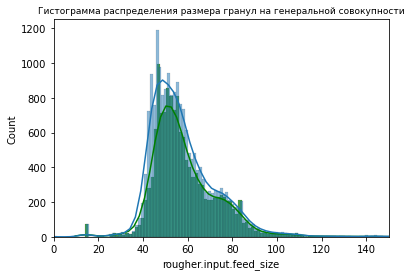

In [35]:
feature_0 = df[0]['rougher.input.feed_size']
feature_2 = df[2]['rougher.input.feed_size']
ax_1 = sns.histplot(x=feature_0, kde=True, color='green', alpha=0.7)
ax_1 = sns.histplot(x=feature_2, kde=True)
ax_1.set_xlim([0, 150])
ax_1.set_title('Гистограмма распределения размера гранул на генеральной совокупности', fontsize=9)

Распределение размеров гранул на обучающей выборке и генеральной совокупности почти совпадают.

Распределение размеров гранул на тестовой выборке слабо похоже на нормальное распределение и имеет четко выраженную бимодальную структуру.
Но несмотря на это распределение на тестовой выборке в целом похоже на распределение на обучающей выборке. Отличие в характере распределения размеров гранул на обучающей и тестовой выборке скажутся негативно на оценку точности модели на тестовой выборке.

Проверим гипотезу о равенстве средних двух независимых выборок, считая что их распределения похожи на нормальное.<br>

Определим нулевую гипотезу H0 так: Средние размеры гранул на обучающей и тестовой выборке равны.<br>
Определим альтернативнуб гипотезу H1 так: Средние размеры гранул на обучающей и тестовой выборке не равны.

In [36]:
# функция вывода результатов ttest с результатами
def ttest(sample_train, sample_test, alpha=0.05):
    print("Cредний размер на обучающей выборке:", sample_train.mean())
    print("Cредний размер на тестовой выборке:", sample_test.mean())
    # тест двусторонний
    _, pvalue = st.ttest_ind(sample_train, sample_test)
    print('p-значение: ', pvalue)
    test_result = [f'Отвергаем нулевую гипотезу: средние размеры скорее на равны при уровне значимости {alpha}.',
                   f'Не получилось отвергнуть нулевую гипотезу: средние размеры скорее равны при уровне значимости {alpha}.']
    print(test_result[0] if pvalue < alpha else test_result[1])

In [37]:
ttest(df[0]['rougher.input.feed_size'], df[1]['rougher.input.feed_size'])

Cредний размер на обучающей выборке: 59.955949804241705
Cредний размер на тестовой выборке: 55.9529165958953
p-значение:  6.374129509652547e-29
Отвергаем нулевую гипотезу: средние размеры скорее на равны при уровне значимости 0.05.


Исходя из результатов нашего ttesta для двух наших выборок мы получили негативный результат, который означает, что на наша модель на тестовой выборке может получить плохую оценку.<br>
Может получить плохую оценку - это не значит, что получит, т.к. данный признак будет участвовать в регрессионной модели с определенным весом и весьма вероятно, что вес этого признака не будет доминировать при расчете прогноза.

**Посмотрим распределение гранул в обучающей и тестовой выборках для этапа первичной очистки (primary_cleaner)**

Text(0.5, 1.0, 'Ящик с усами размера гранул на обучающей выборке')

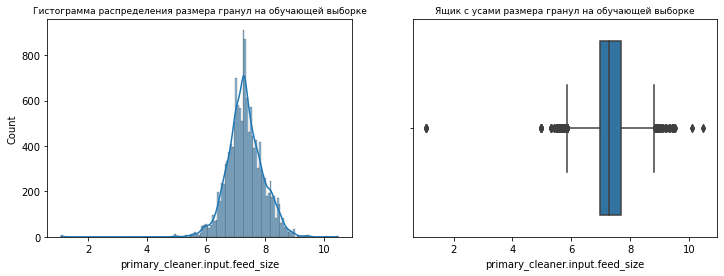

In [38]:
# Распределение и ящик с усами размера гранул для обучающей выборки
feature = df[0]['primary_cleaner.input.feed_size']

fig = plt.figure(figsize=(12,4))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
sns.histplot(x=feature, kde=True, ax=ax_1)
ax_2 = sns.boxplot(x=feature, ax=ax_2)
ax_1.set_title('Гистограмма распределения размера гранул на обучающей выборке', fontsize=9)
ax_2.set_title('Ящик с усами размера гранул на обучающей выборке', fontsize=9)

Из графика видно, что на обучающей выборке на входе в этап первичной очистки мы видим симметричное и похожее на нормальное распределение размеров гранул. Мы также видим незначительное количество статистических выбросов как справа, так и слева.<br>

Посмотрим распределение на тестовой выборке.

Text(0.5, 1.0, 'Ящик с усами размера гранул на обучающей выборке')

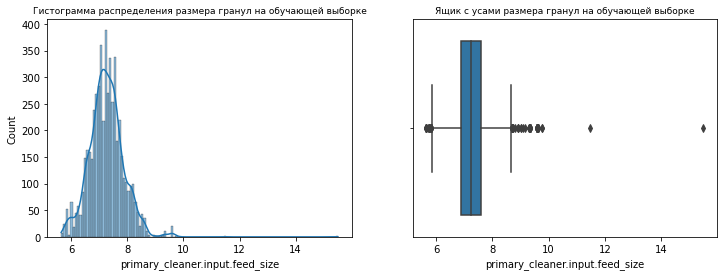

In [39]:
# Распределение и ящик с усами размера гранул для обучающей выборки
feature = df[1]['primary_cleaner.input.feed_size']

fig = plt.figure(figsize=(12,4))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
sns.histplot(x=feature, kde=True, ax=ax_1)
ax_2 = sns.boxplot(x=feature, ax=ax_2)
ax_1.set_title('Гистограмма распределения размера гранул на обучающей выборке', fontsize=9)
ax_2.set_title('Ящик с усами размера гранул на обучающей выборке', fontsize=9)

На тестовой выборке распределение размеров гранул на этапе первичной очистки также похоже на нормальное распределение с небольшим количеством статистических выбросов справа.

Посмотрим на эти распределения с учетом уменьшения границы областей значений (xlim), т.е. уберем с графиков выбросы.

Text(0.5, 1.0, 'Гистограмма распределения размера гранул на тестовой выборке')

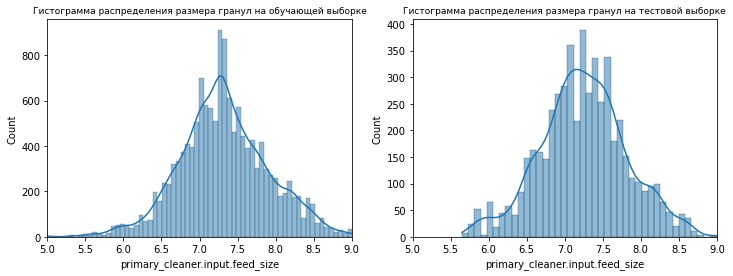

In [40]:
feature_0 = df[0]['primary_cleaner.input.feed_size']
feature_1 = df[1]['primary_cleaner.input.feed_size']

fig = plt.figure(figsize=(12,4))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
ax_1 = sns.histplot(x=feature_0, kde=True, ax=ax_1)
ax_1.set_xlim([5, 9])
ax_2 = sns.histplot(x=feature_1, kde=True, ax=ax_2)
ax_2.set_xlim([5, 9])
ax_1.set_title('Гистограмма распределения размера гранул на обучающей выборке', fontsize=9)
ax_2.set_title('Гистограмма распределения размера гранул на тестовой выборке', fontsize=9)

Мы наблюдаем на графиках практически идентичные распределения размеров гранул близкие к нормальному распределению. 

Проверим гипотезу о равенстве средних двух независимых выборок (обучающей и тестовой), считая что их распределения похожи на нормальное.<br>

Определим нулевую гипотезу H0 так: Средние размеры гранул на обучающей и тестовой выборке равны. <br>
Определим альтернативную гипотезу H1 так: Средние размеры гранул на обучающей и тестовой выборке не равны.

In [42]:
ttest(df[0]['primary_cleaner.input.feed_size'], df[1]['primary_cleaner.input.feed_size'])

Cредний размер на обучающей выборке: 7.322309906901298
Cредний размер на тестовой выборке: 7.266339191270909
p-значение:  1.4864182925957636e-08
Отвергаем нулевую гипотезу: средние размеры скорее на равны при уровне значимости 0.05.


Исходя из результатов нашего ttesta для двух наших выборок мы получили негативный результат, который означает, что наша модель на тестовой выборке может получить плохую оценку.
Может получить плохую оценку - это не значит, что получит, т.к. данный признак будет участвовать в регрессионной модели с определенным весом и весьма вероятно, что вес этого признака не будет доминировать при расчете прогноза.

**Резюме:**<br>
Статистический тест показал статистически значимое отличие размеров для этапов флотации и первичной очистки. Данный факт может действительно плохо повлиять на обучение нашей модели. Вероятно, что придется отказаться использования данного признака в нашей модели ML.

## 2.3. Анализ суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Посчитаем суммарную концентрацию металлов на этапах флотации, первичной очистки, вторичной очистки и финал.

Вещество sol не относится к металлам.

Сделаем два анализа суммарной концентрации - металлов и всех химических вещществ (металлы + sol).

**Анализ динамики изменения концентрации металлов по этапам.**

In [43]:
rougher_input =   df[0]['rougher.input.feed_au'] + \
                  df[0]['rougher.input.feed_ag'] + \
                  df[0]['rougher.input.feed_pb'] 
rougher_output =  df[0]['rougher.output.concentrate_au'] + \
                  df[0]['rougher.output.concentrate_ag'] + \
                  df[0]['rougher.output.concentrate_pb']
primary_cleaner = df[0]['primary_cleaner.output.concentrate_au'] + \
                  df[0]['primary_cleaner.output.concentrate_ag'] + \
                  df[0]['primary_cleaner.output.concentrate_pb']
final =           df[0]['final.output.concentrate_au'] + \
                  df[0]['final.output.concentrate_ag'] + \
                  df[0]['final.output.concentrate_pb']

metal_concentrate = pd.concat([rougher_input, rougher_output, primary_cleaner, final], axis=1)
metal_concentrate.columns = ['rougher_input', 'rougher_output', 'primary_cleaner', 'final']

Посмотрим изменения в динамике по этапам средних значений

Text(0.5, 1.0, 'Динамика среднего значения концентрации металлов')

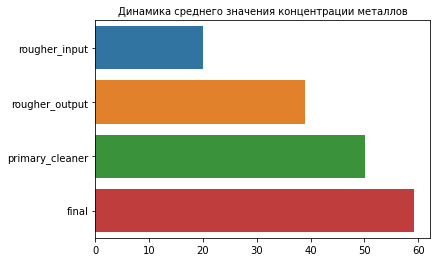

In [44]:
rougher_input = metal_concentrate.rougher_input.mean()
rougher_output = metal_concentrate.rougher_output.mean()
primary_cleaner = metal_concentrate.primary_cleaner.mean()
final = metal_concentrate.final.mean()

sns.barplot(y=metal_concentrate.columns,
                   x=[rougher_input, rougher_output, primary_cleaner, final]).\
    set_title(f'Динамика среднего значения концентрации металлов', fontsize=10)

Text(0.5, 1.0, 'Динамика распределения концентрации металлов на этапах техпроцесса')

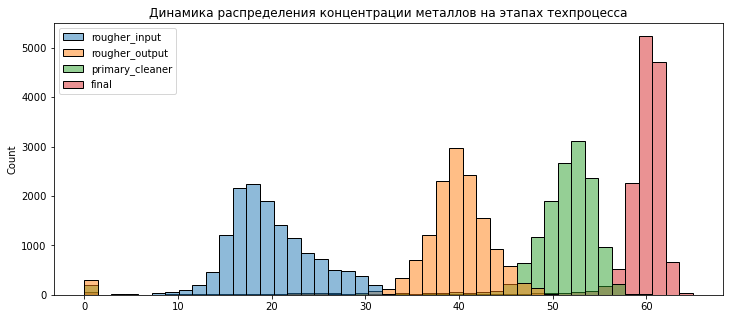

In [45]:
fig = plt.figure(figsize=(12,5))
ax_1 = sns.histplot(data = metal_concentrate)
ax_1.set_title(f'Динамика распределения концентрации металлов на этапах техпроцесса', fontsize=12)

На графике наблюдаем 3хкратный рост уровня общей концентрации металлов от входа до финала. По всем этапам технологического процесса происходит увеличение концентрации металлов. Особенно большой скачок наблюдается после этапа флотации, где за один этап происходит двукратное увеличение концентрации металла. Первичная и вторичная очистки дают в совокупности рост концентрации в 1,5 раза.<br>
Кроме этого, мы наблюдаем довольно существенное уменьшение дисперсии распределения концентрации металлов от этапа к этапу.

**Анализ динамики изменения концентрации металлов и sol по этапам.**

In [46]:
rougher_input =   df[0]['rougher.input.feed_au'] + \
                  df[0]['rougher.input.feed_ag'] + \
                  df[0]['rougher.input.feed_pb'] + \
                  df[0]['rougher.input.feed_sol']

rougher_output =  df[0]['rougher.output.concentrate_au'] + \
                  df[0]['rougher.output.concentrate_ag'] + \
                  df[0]['rougher.output.concentrate_pb'] + \
                  df[0]['rougher.output.concentrate_sol']

primary_cleaner = df[0]['primary_cleaner.output.concentrate_au'] + \
                  df[0]['primary_cleaner.output.concentrate_ag'] + \
                  df[0]['primary_cleaner.output.concentrate_pb'] + \
                  df[0]['primary_cleaner.output.concentrate_sol']

final =           df[0]['final.output.concentrate_au'] + \
                  df[0]['final.output.concentrate_ag'] + \
                  df[0]['final.output.concentrate_pb'] + \
                  df[0]['final.output.concentrate_sol']
chemical_concentrate = pd.concat([rougher_input, rougher_output, primary_cleaner, final], axis=1)
chemical_concentrate.columns = ['rougher_input', 'rougher_output', 'primary_cleaner', 'final']

Посмотрим изменения в динамике по этапам средних значений

Text(0.5, 1.0, 'Динамика среднего значения концентрации химических веществ')

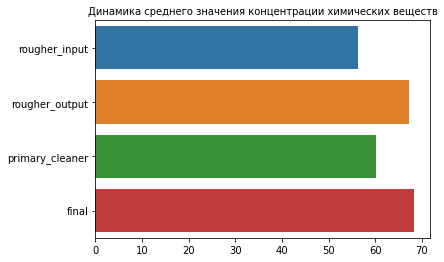

In [47]:
rougher_input = chemical_concentrate.rougher_input.mean()
rougher_output = chemical_concentrate.rougher_output.mean()
primary_cleaner = chemical_concentrate.primary_cleaner.mean()
final = chemical_concentrate.final.mean()

sns.barplot(y=['rougher_input', 'rougher_output', 'primary_cleaner', 'final'],
                   x=[rougher_input, rougher_output, primary_cleaner, final]).\
    set_title(f'Динамика среднего значения концентрации химических веществ', fontsize=10)

Text(0.5, 1.0, 'Динамика распределения концентрации металлов на этапах техпроцесса')

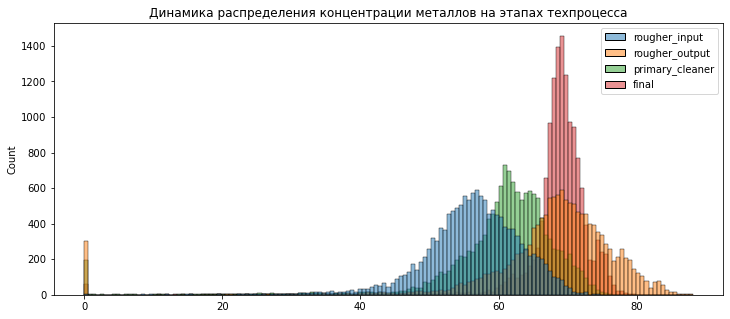

In [48]:
fig = plt.figure(figsize=(12,5))
ax_1 = sns.histplot(data = chemical_concentrate)
ax_1.set_title(f'Динамика распределения концентрации металлов на этапах техпроцесса', fontsize=12)

Если рассматривать в целом все четыре химических вещества - три металла (Au, Ag и Pb) и третье вещество Sol, то не увидим законномерности роста концентрации, т.к. после первичной очистки суммарная концентрация целевых химических веществ упала. В конечном итоге после вторичной очистки суммарная концентрация выросла относительно входных показателей (feed) и относительно выходных показателей этапа первичной очистки.<br>
Также мы наблюдаем существенное уменьшение дисперсии, но в отличии от металлов только на финальном этапе.

# Шаг 3. Построение модели.

## Шаг 3.1. Функция для вычисления итоговой sMAPE.

Напишем функцию, которая будет вычислять метрику sMAPE для сравнения истинного значения с предсказанным значением, а также функцию, которая будет вычислять итоговую или финальную метрику sMAPE как взвешанные по заданным веса значения метрики sMAPE для предсказанных величин эффективности  производства чернового концентрата и производство финального концентрата.

**С данной метрикой есть проблема!** В знаменателе стоит сумма двух компонент истинных и предсказанных значений. Если они равны нулю, то будет ошибка деления на ноль, если они не равны нулю, но находятся близко к нему (0,0001 или 0,00005), то получим очень большое число. Т.е. эта метрика подходит только для не близких к нулю значений компонент.

Этот факт мы не будем отражать в нашей функции smape(), а учтем его на обучающей выборке - удалим все "плохие" с этой точки зрения объекты.

In [77]:
def final_smape_2(target, predict):
    # target и predict - это матрицы 2 х Len(data_train), где первый солбец - это относится к rougher, а второй к final
    # target - это dataframe pandas
    # переведем все массивы в numpy
    
    target_rougher = target.to_numpy().T[0]
    predict_rougher = predict.T[0]
    smape = np.abs(target_rougher - predict_rougher) / (np.abs(target_rougher) + np.abs(predict_rougher)) / 2
    smape_rougher = 100 * np.mean(smape)

    target_final = target.to_numpy().T[1]
    predict_final = predict.T[1]
    smape = np.abs(target_final - predict_final) / (np.abs(target_final) + np.abs(predict_final)) / 2
    smape_final = 100  *np.mean(smape)
 
    return 0.25 * smape_rougher +  0.75 * smape_final

# Опредедим на основе этой функции собственную метрику
final_smape_score = make_scorer(final_smape_2, greater_is_better=False)

## Шаг 3.2. Обучение нескольких моделей и оценка их качества через кросс-валидацию. Определение лучшей модели и проверка её на тестовой выборке. 

Для обучения будем использовать три типа моделей - линейная модель (LinearRegression), случайный лес (RandomForestRegressor) и градиентный бустинг версии sklearn (GradientBoostingRegressor).

В рамках обучения будем использовать методику кросс-валидации. Кросс-валидацию будем делать вручную без использования подборщиков, чтобы показать базовые навыки владения данным инсттрументом.

Наш датасет содержит большое количество признаков и нам нужно будет отобрать из них те, которые будут независимы между собой и реально влиять на конечные целевые признаки.

По условиям задания нам нужно будет спрогнозировать сразу две величины:<br>
эффективность обогащения чернового концентрата rougher.output.recovery;<br>
эффективность обогащения финального концентрата final.output.recovery.<br>
Т.е. у нас будут две модели ML. <br>
Т.к. по технологическому процессу эффективность обогощения финального концентрата зависит от эффективности обогащения чернового концентрата, то нам нужно будет еще составить композицию этих двух зависимых величин.

Таким образом, вырисовывается две задачи:
1. Выбрать признаки для двух моделей.
2. Выбрать композицию моделей.

Плюс к этому хотелось добавить, что т.к. это "реальное производство", то модель желательно должна быть интерпретируемой. Я заранее склоняюсь к тому, чтобы выбрать линейную регрессию, но мы все равно обучим несколько моделей разных типов. 

**Выберем признаки для наших моделей**

Я буду руководствоваться такой логикой - есть характеристики золоторудного сырья и есть параметры техпроцесса, которые настраиваются для процесса флотации, первичной и вторичной очистки и результаты очистики (концентрации продукта и отвалов) зависят от этих параметров. (Нигде это не описано, это чисто мое предположение). 

И еще один момент процесс флотации идет на установке Float banks 10 и на основании этого признаки установки Float banks 11 будут проигнорированы. (Нигде это не описано, это тоже чисто мое предположение).

Наш выбор признаков будет означать зависимость целевого признака от параметров руды, загружаемых химикатов, и параметров установок для флотации,первичной и вторичной очистки.

В рамках анализа данных выяснилось, что признак size плохой для построения нашей модели и поэтому мы его удалим из нашего списка. 

Тестовая выборка будет являтся датасетом из которой мы будем отбирать нужные нам признаки для ML. Я предполагаю она нам для этого дана ззаранее, чтобы ориентироваться на нее при выборе признаков.

Посмотрим все признаки тестовой выборки, а для выбора признаков немного логически поразмышляем по технологическому процессу.

**Признаки этапа флотации:**<br>
rougher.input.feed_pb,<br>
rougher.input.feed_rate,<br>
rougher.input.feed_size,<br>
rougher.input.feed_sol,<br>
rougher.input.feed_au,<br>
rougher.input.floatbank10_sulfate,<br>
rougher.input.floatbank10_xanthate,<br>
rougher.input.floatbank11_sulfate,<br>
rougher.input.floatbank11_xanthate,<br>
rougher.state.floatbank10_a_air,<br>
rougher.state.floatbank10_a_level,<br>
rougher.state.floatbank10_b_air,<br>
rougher.state.floatbank10_b_level,<br>
rougher.state.floatbank10_c_air,<br>
rougher.state.floatbank10_c_level,<br>
rougher.state.floatbank10_d_air,<br>
rougher.state.floatbank10_d_level,<br>
rougher.state.floatbank10_e_air,<br>
rougher.state.floatbank10_e_level,<br>
rougher.state.floatbank10_f_air<br>

Из данного набора признаков мы видим загрузку сырья (feed), химикатов (sulfate и xanthate) в установку floatbank10, этих же химикатов в установку floatbank11 и параметры настройки работы установки floatbank10. Установка floatbank11 не участвует в работе производства чернового концентрата.<br>
Таким образом, из данного набора признаков мы берем все признаки, кроме rougher.input.feed_size, ougher.input.floatbank11_sulfate и rougher.input.floatbank11_xanthate.

**Признаки этапа первичной очистки:**<br>

primary_cleaner.input.sulfate,<br>
primary_cleaner.input.depressant,<br>
primary_cleaner.input.feed_size,<br>
primary_cleaner.input.xanthate,<br>

primary_cleaner.state.floatbank8_a_air,<br>
primary_cleaner.state.floatbank8_a_level,<br>
primary_cleaner.state.floatbank8_b_air,<br>
primary_cleaner.state.floatbank8_b_level,<br>
primary_cleaner.state.floatbank8_c_air,<br>
primary_cleaner.state.floatbank8_c_level,<br>
primary_cleaner.state.floatbank8_d_air,<br>
primary_cleaner.state.floatbank8_d_level'

primary_cleaner.output.concentrate_ag,<br>
primary_cleaner.output.concentrate_pb,<br>
primary_cleaner.output.concentrate_sol,<br>
primary_cleaner.output.concentrate_au,<br>

primary_cleaner.output.tail_ag,<br>
primary_cleaner.output.tail_pb,<br>
primary_cleaner.output.tail_sol,<br>
primary_cleaner.output.tail_au<br>

На вход данного этапа подается продукт с флотационной установки (Float banks 10) с характеристиками concentrate, которые являются аргументами функции расчета эффективности производства чернового концентрата - целевой функции нашей первой модели.
Из данного набора признаков блок признаков concentrate и tail являются зависимыми от блоков признаков input и state. 
Таким образом из данного этапа мы выбираем признаки блока input:<br>
primary_cleaner.input.sulfate, <br>
primary_cleaner.input.depressant,<br>
primary_cleaner.input.xanthate<br>
и признаки блока state:<br>
primary_cleaner.state.floatbank8_a_air,<br>
primary_cleaner.state.floatbank8_a_level,<br>
primary_cleaner.state.floatbank8_b_air,<br>
primary_cleaner.state.floatbank8_b_level,<br>
primary_cleaner.state.floatbank8_c_air,<br>
primary_cleaner.state.floatbank8_c_level,<br>
primary_cleaner.state.floatbank8_d_air,<br>
primary_cleaner.state.floatbank8_d_level<br>

**Признаки этапа вторичной очистки:**<br>

secondary_cleaner.state.floatbank2_a_air,<br>
secondary_cleaner.state.floatbank2_a_level,<br>
secondary_cleaner.state.floatbank2_b_air,<br>
secondary_cleaner.state.floatbank2_b_level,<br>
secondary_cleaner.state.floatbank3_a_air,<br>
secondary_cleaner.state.floatbank3_a_level,<br>
secondary_cleaner.state.floatbank3_b_air,<br>
secondary_cleaner.state.floatbank3_b_level,<br>
secondary_cleaner.state.floatbank4_a_air,<br>
secondary_cleaner.state.floatbank4_a_level,<br>
secondary_cleaner.state.floatbank4_b_air,<br>
secondary_cleaner.state.floatbank4_b_level,<br>
secondary_cleaner.state.floatbank5_a_air,<br>
secondary_cleaner.state.floatbank5_a_level,<br>
secondary_cleaner.state.floatbank5_b_air,<br>
secondary_cleaner.state.floatbank5_b_level,<br>
secondary_cleaner.state.floatbank6_a_air,<br>
secondary_cleaner.state.floatbank6_a_level<br>

final.output.concentrate_au,<br>
final.output.concentrate_ag,<br>
final.output.concentrate_pb,<br>
final.output.concentrate_sol<br>

secondary_cleaner.output.tail_ag,<br>
secondary_cleaner.output.tail_pb,<br>
secondary_cleaner.output.tail_sol,<br>
secondary_cleaner.output.tail_au<br>  

На вход этапа вторичной очистки подается продукт с этапа первичной очистки с характеристиками concentrate и без каких либо химических реагентов попадает на установку Float banks 2, далее он переходит на устновку Float banks 3, далее на установку Float banks 4, далее на установку Float banks 5 и далее на установку Float banks 6, из которой выходит финальный продукт с характеристиками concentrate, а образовавшийся отвал обладает характеристиками tail. Характеристики итогового продукта и отвала являются аргументами функции расчета эффективности производства финального продукта.
Таким образом, из данного набора признаков мы выберем все признаки блока state.

Исходя из проведенного выше описания технологического процесса обогащения золоторудного сырья можно сделать следующий вывод, что эффективность производства финального продукта зависит от следующих признаков:<br>
А. Этап флотация.<br>
rougher.input.feed_pb,<br>
rougher.input.feed_rate,<br>
rougher.input.feed_sol,<br>
rougher.input.feed_au,<br>
rougher.input.floatbank10_sulfate,<br>
rougher.input.floatbank10_xanthate,<br>
rougher.state.floatbank10_a_air,<br>
rougher.state.floatbank10_a_level,<br>
rougher.state.floatbank10_b_air,<br>
rougher.state.floatbank10_b_level,<br>
rougher.state.floatbank10_c_air,<br>
rougher.state.floatbank10_c_level,<br>
rougher.state.floatbank10_d_air,<br>
rougher.state.floatbank10_d_level,<br>
rougher.state.floatbank10_e_air,<br>
rougher.state.floatbank10_e_level,<br>
rougher.state.floatbank10_f_air<br>
Б. Этап первичной очистки.<br>
    primary_cleaner.input.sulfate,<br>
    primary_cleaner.input.depressant,<br>
    primary_cleaner.input.xanthate,<br>
    primary_cleaner.state.floatbank8_a_air,<br>
    primary_cleaner.state.floatbank8_a_level,<br>
    primary_cleaner.state.floatbank8_b_air,<br>
    primary_cleaner.state.floatbank8_b_level,<br>
    primary_cleaner.state.floatbank8_c_air,<br>
    primary_cleaner.state.floatbank8_c_level,<br>
    primary_cleaner.state.floatbank8_d_air,<br>
    primary_cleaner.state.floatbank8_d_level<br>
В. Этап вторичной очистки.<br>
    secondary_cleaner.state.floatbank2_a_air,<br>
    secondary_cleaner.state.floatbank2_a_level,<br>
    secondary_cleaner.state.floatbank2_b_air,<br>
    secondary_cleaner.state.floatbank2_b_level,<br>
    secondary_cleaner.state.floatbank3_a_air,<br>
    secondary_cleaner.state.floatbank3_a_level,<br>
    secondary_cleaner.state.floatbank3_b_air,<br>
    secondary_cleaner.state.floatbank3_b_level,<br>
    secondary_cleaner.state.floatbank4_a_air,<br>
    secondary_cleaner.state.floatbank4_a_level,<br>
    secondary_cleaner.state.floatbank4_b_air,<br>
    secondary_cleaner.state.floatbank4_b_level,<br>
    secondary_cleaner.state.floatbank5_a_air,<br>
    secondary_cleaner.state.floatbank5_a_level,<br>
    secondary_cleaner.state.floatbank5_b_air,<br>
    secondary_cleaner.state.floatbank5_b_level,<br>
    secondary_cleaner.state.floatbank6_a_air,<br>
    secondary_cleaner.state.floatbank6_a_level

Посмотрим корреляцию признаков всех трех этапов без учета промежуточных итогов и расчетных характеристик, т.е. так как-будто это был бы непрерывный процесс.

In [78]:
# это список, выбранных мной признаков для обучения.
list_features = [
'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',    
'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_a_air',
'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level',
'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level',
'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank2_b_air',
'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_a_level',
'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank4_a_air',
'secondary_cleaner.state.floatbank4_a_level', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_b_level',
'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level', 'secondary_cleaner.state.floatbank5_b_air',
'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank6_a_level'
]

Признаков очень много и посмотреть на графиках корреляцию не реально. Сделаем таблицу попарных корреляция из них выберем пары с сильной корреляцией - больше или равно 0,7.

In [79]:
# напишем функцию, которая выдает информацию о сильно коррелирующих признаках
def hard_corr(data):
    table_corr = data.corr()
    list_corr = []
    for col in table_corr.columns:
        for idx in table_corr.index:
            if 0.7 <= abs(table_corr.loc[idx, col]) < 1.0:
                list_corr.append((idx, column, round(table_corr.loc[idx, col], 4))) 
    # Удалим повторы
    list_hard_corr = sorted(list_corr, key=lambda x: x[2])
    return [list_hard_corr[i] for i in range(0, len(list_hard_corr), 2)]

In [80]:
print('Количество сильно коррелирущих признаков =', len(hard_corr(df[0][list_features])))
print('Вот они:')
for x in hard_corr(df[0][list_features]):
    print(x)

Количество сильно коррелирущих признаков = 39
Вот они:
('primary_cleaner.state.floatbank8_d_level', 'secondary_cleaner.state.floatbank6_a_level', 0.7029)
('secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank6_a_level', 0.7034)
('secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank6_a_level', 0.7071)
('rougher.state.floatbank10_e_air', 'secondary_cleaner.state.floatbank6_a_level', 0.7092)
('secondary_cleaner.state.floatbank4_a_level', 'secondary_cleaner.state.floatbank6_a_level', 0.7212)
('secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank6_a_level', 0.723)
('secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank6_a_level', 0.7473)
('secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank6_a_level', 0.7511)
('rougher.state.floatbank10_f_air', 'secondary_cleaner.state.floatbank6_a_level', 0.7575)
('rougher.state.floatbank10_e_air', 'secondary_cleaner.state.floatb

Уберем их из списка признаков для построения модели ML

In [81]:
# Очищенный от сильно коррелирующих признаков список и добавим в него целевые признаки
list_features =    ['rougher.output.recovery',
                    'rougher.input.feed_pb',
                    'rougher.input.feed_rate',
                    'rougher.input.feed_sol',
                    'rougher.input.feed_au',
                    'rougher.input.floatbank10_sulfate',
                    'rougher.input.floatbank10_xanthate',
                    'rougher.state.floatbank10_a_air', 
                    'rougher.state.floatbank10_a_level',
                    'rougher.state.floatbank10_b_air', 
                    'rougher.state.floatbank10_b_level',
                    'primary_cleaner.input.sulfate',
                    'primary_cleaner.input.depressant',
                    'primary_cleaner.input.xanthate',
                    'primary_cleaner.state.floatbank8_a_air',
                    'primary_cleaner.state.floatbank8_a_level',
                    'primary_cleaner.state.floatbank8_d_air',
                    'primary_cleaner.state.floatbank8_d_level',
                    'secondary_cleaner.state.floatbank2_a_air',
                    'secondary_cleaner.state.floatbank2_a_level',
                    'secondary_cleaner.state.floatbank3_a_air',
                    'secondary_cleaner.state.floatbank3_a_level',
                    'secondary_cleaner.state.floatbank3_b_air',
                    'secondary_cleaner.state.floatbank3_b_level',
                    'secondary_cleaner.state.floatbank4_a_air',
                    'secondary_cleaner.state.floatbank6_a_air',
                    'secondary_cleaner.state.floatbank6_a_level',
                    'final.output.recovery']

In [82]:
# проверка
print('Количество сильно коррелирущих признаков =', len(hard_corr(df[0][list_features])))

Количество сильно коррелирущих признаков = 0


Таким образом, мы определили наборы признаков для построения моделей машинного обучения.

**Определим композицию моделей прогнозирования rougher.output.recovery и final.output.recovery**

Схематично зависимость rougher.output.recovery от признаков можно изложить фактически одним способом:<br>
rougher.output.recovery = F_rougher(set_features_rougher)<br>

А final.output.recovery можно изложить уже двумя способами:<br>
Первый способ:<br>
 final.output.recovery = F_final(set_all_features)<br>
Второй способ:<br>
 final.output.recovery = G_final(rougher.output.recovery, set_prime_features, set_second_features), где переменная rougher.output.recovery в свою очередь уже зависит от набора признаков этапа флотации.<br>
 
В первом способе зависимость final.output.recovery строится от всего набора признаков нашего технологического процесса, которые мы определим, а во втором способе мы строим зависимость от ранее расчитанного признака rougher.output.recovery и от набора признаков первичной и вторичной очистки. Т.е. во втором способе мы может сделать сложную зависимость и она будет выглядеть красивее для нашей метрики final_sMAPE, но если мы будем использовать второй способ то разброс ошибок может оказаться больше, т.к. мы будем строить предсказания от предсказанного.<br>

Если мы выберем первый способ и будем строить две независимые модели предсказания rougher.output.recovery и final.output.recovery, то мы получим две разные и независимые друг от друга модели на одном фактически едином технологическом процессе. Все что их будет объединять это общие признаки и метрика final_sMAPE их композиции, а причинно-следственная связь будет отсутствовать.

Таким образом, выберем первый способ.

**Резюме:**<br>
Таким образом, мы определили набор признаков для обучения моделей и определились с композицей моделей.

**Перейдем к созданию кросс-валидирующих выборок для модели предсказания rougher.output.recovery**

Процесс моделирования будет следующим:<br>
1. Создаем датасет для обучения.
2. Из обучающей выборки удаляем все объекты с "плохими" значениями rougher.output.recovery и final.output.recovery для нашей метрики sMAPE.<br>
3. На обучающей выборке делаем кросс-валидирующие выборки.<br>
4. Обучаем модели прогнозирования rougher.output.recovery и final.output.recovery. Причем делаем один тип модели с набором гиперпараметров для двух моделей обучения.<br>
5. Из набора моделей по метрике final_sMAPE выбираем лучшую и проверяем ее на тестовой выборке.

In [83]:
data = pd.DataFrame(df[0][list_features])
data = data.reset_index(drop=True)

Удалим все объекты с "плохими" значениями для метрики sMAPE эффективности производства концентрата. Критерием отнесения объекта к категории "плохо" будем считать = 1%.

In [84]:
data = data[data['rougher.output.recovery'] >= 1]
data = data[data['final.output.recovery'] >= 1]
print('Из', len(df[0]), 'записей в обучающей выборке после удаления осталось', len(data), 'записей или', round(100*len(data)/len(df[0]), 1), '%')

Из 14149 записей в обучающей выборке после удаления осталось 13792 записей или 97.5 %


Выделим целевые признаки и признаки для обучения.

In [85]:
data_train = data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
data_target = data[['rougher.output.recovery', 'final.output.recovery']]

Сделаем кросс-валидирующие выборки, на них обучим модели посчитаем метрику final_sMAPE.

Выборки, обучение и и расчет метрики будет делать функция, которая на вход будет принимать модель, исходный датасет и количество разбиений (cv).
Можно было воспользовать оценкой метрики из sklearn 

In [86]:
def cross_valid(model, features, target, cv):
    
    score = []
    sample_size = int(len(features)/cv)
    
    for i in range(0, len(data), sample_size):
        valid_indexes = list(features.index[i:i+sample_size])
        train_indexes = set(features.index).difference(valid_indexes)
        
        features_train =  features.loc[train_indexes]
        target_train = target.loc[train_indexes]
        
        features_valid = features.loc[valid_indexes] 
        target_valid = target.loc[valid_indexes]

        model = model.fit(features_train, target_train)
        score.append(final_smape_2(target_valid, model.predict(features_valid)))
    return [model, round(mean(score), 4)]

**Обучим линейную регрессию**

In [87]:
models = []
model=LinearRegression()
models.append(cross_valid(model, data_train, data_target, 3))
cross_valid(model, data_train, data_target, 3)

[LinearRegression(), 1.8991]

Вариант с cross_val_score()

In [88]:
model=LinearRegression()
#model.fit(data_train, data_target)
[model, round(mean(abs(cross_val_score(model, data_train, data_target, cv=3, scoring=final_smape_score))), 4)]

[LinearRegression(), 2.4831]

**Обучим методом случайного леса**

In [89]:
for est in tqdm([10, 20]):
    for depth in [7, 9]:
        model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        models.append(cross_valid(model, data_train, data_target, 3))
sorted(models, key=lambda x: x[1])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:55<00:00, 27.74s/it]


[[LinearRegression(), 1.8991],
 [RandomForestRegressor(max_depth=7, n_estimators=20, random_state=12345),
  2.3198],
 [RandomForestRegressor(max_depth=7, n_estimators=10, random_state=12345),
  2.3565],
 [RandomForestRegressor(max_depth=9, n_estimators=20, random_state=12345),
  2.5002],
 [RandomForestRegressor(max_depth=9, n_estimators=10, random_state=12345),
  2.6611]]

**Резюме:**<br>
Лучшей моделью оказалась линейная регрессия. 

Посмотрим как работает наша модель на тестовой базе.
Предварительно к тестовой базе из исходного датасета добавим отсутствующие в ней целевые признаки. 

In [90]:
df[1]['rougher.output.recovery'] = df[2]['rougher.output.recovery'][df[1].index]
df[1]['final.output.recovery'] = df[2]['final.output.recovery'][df[1].index]

In [91]:
data_test = df[1][list_features]
data_test_features = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
data_test_target = data_test[['rougher.output.recovery', 'final.output.recovery']]

In [92]:
best_model = models[0][0]
print('На тесте значение метрики final_sMAPE=', round(final_smape_2(data_test_target, best_model.predict(data_test_features)), 4))

На тесте значение метрики final_sMAPE= 2.3075


Построим примитивную модель с помощью функции DummyRegressor().<br>
У нас распределение целевых признаков почти похоже на нормальное распределение, поэтому без разницы какой стратегии придерживаться - медианое или среднее значение.<br>
Возьмем медианное значение

In [93]:
dummy_regressor = DummyRegressor(strategy="median")
dummy_regressor.fit(data_train, data_target)
print('Оценка прогнозов примитивной модели =', final_smape_2(data_test_target, dummy_regressor.predict(data_test_features))) 

Оценка прогнозов примитивной модели = 2.359606217489136


# Выводы.

В результате подбора модели машинного обучения для предсказывания эффективности обогащения золота из рудного сырья по характеристикам рудного сырья и параметрам технологического процесса обогащения была признана лучшей линейная модель по метрике final_sMAPE, котопая является линейно комбинацией двух предсказываемых величин - эффективность производства черного концентрата и эффективность производства финального концентрата. Обучение модели осуществлялось с использованием методики кросс-валидации, с количеством разбиений обучающего датасета равным трем.<br>
Лучшая модель на обучении и кросс-валидации показала значение метрики final_sMAPE=1.8991, а на тестовой выборке final_sMAPE=2.3075.
Следует отметить, что примитивная модель дала на тестовой выборке результат чуть хуже, чем наша модель по нашей метрике final_sMAPE.